In [10]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import scipy.ndimage as img
import scipy.signal as sig
from PIL import Image, ImageDraw, ImageFont
from jupyterthemes import jtplot

In [11]:
jtplot.reset()
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"

In [79]:
class ImgModel:
    
    def generate_aperture(rad=0.5, res=500):
        t = np.linspace(-1, 1, res)
        X, Y = np.meshgrid(t,t)
        R = np.hypot(X, Y)
        Z = np.zeros((res, res))
        Z[R <= rad] = 1
        Z = np.round(Z/Z.max() * 255).astype("uint8")
        return Z
        
    def generate_txtImage(x, y, dims=512, text=None, fontsize=256, fontcolor="white", bgcolor="black", supersample=True, superes=128):
        a = Image.new("L", (dims, dims), color=bgcolor)
        fnt = ImageFont.truetype("C:/Windows/Fonts/Arial.ttf", fontsize)
        d = ImageDraw.Draw(a)
        d.text((x, y), text, font=fnt, fill=fontcolor)
        if supersample:
            a = a.resize((superes, superes), Image.ANTIALIAS)
        a = np.array(a, "uint8")
        return a
    
    def image_aperture(obj, aper):
        Faper = fft.fftshift(aper)
        Fobj = fft.fft2(obj)
        FRA = Faper*Fobj
        IRA = abs(fft.fft2(FRA))
        FImage = np.round(IRA/IRA.max() * 255).astype("uint8")
        return FImage
    
def uint8(X):
    return np.round(abs(X)/abs(X).max() * (2**8 - 1)).astype("uint8")

def fftcircle(Z, r, h, k, **kwargs):
    draw = ImageDraw.Draw(Z)
    draw.ellipse((h-r, k-r, h+r, k+r), **kwargs)

def fftsquare(Z, r, h, k, **kwargs):
    draw = ImageDraw.Draw(Z)
    draw.rectangle((h-r, k-r, h+r, k+r), **kwargs)
    
def fftgauss(X, Y, mux, muy, sigma):
    return np.exp(-((X - mux/len(X))**2 + (Y - muy/len(Y))**2)**2/sigma**2)

## Activity 1. Familiarization with discrete FFT

A $128 \times 128$ Boolean image of a centered circle is created, and the 2D FFT is taken.

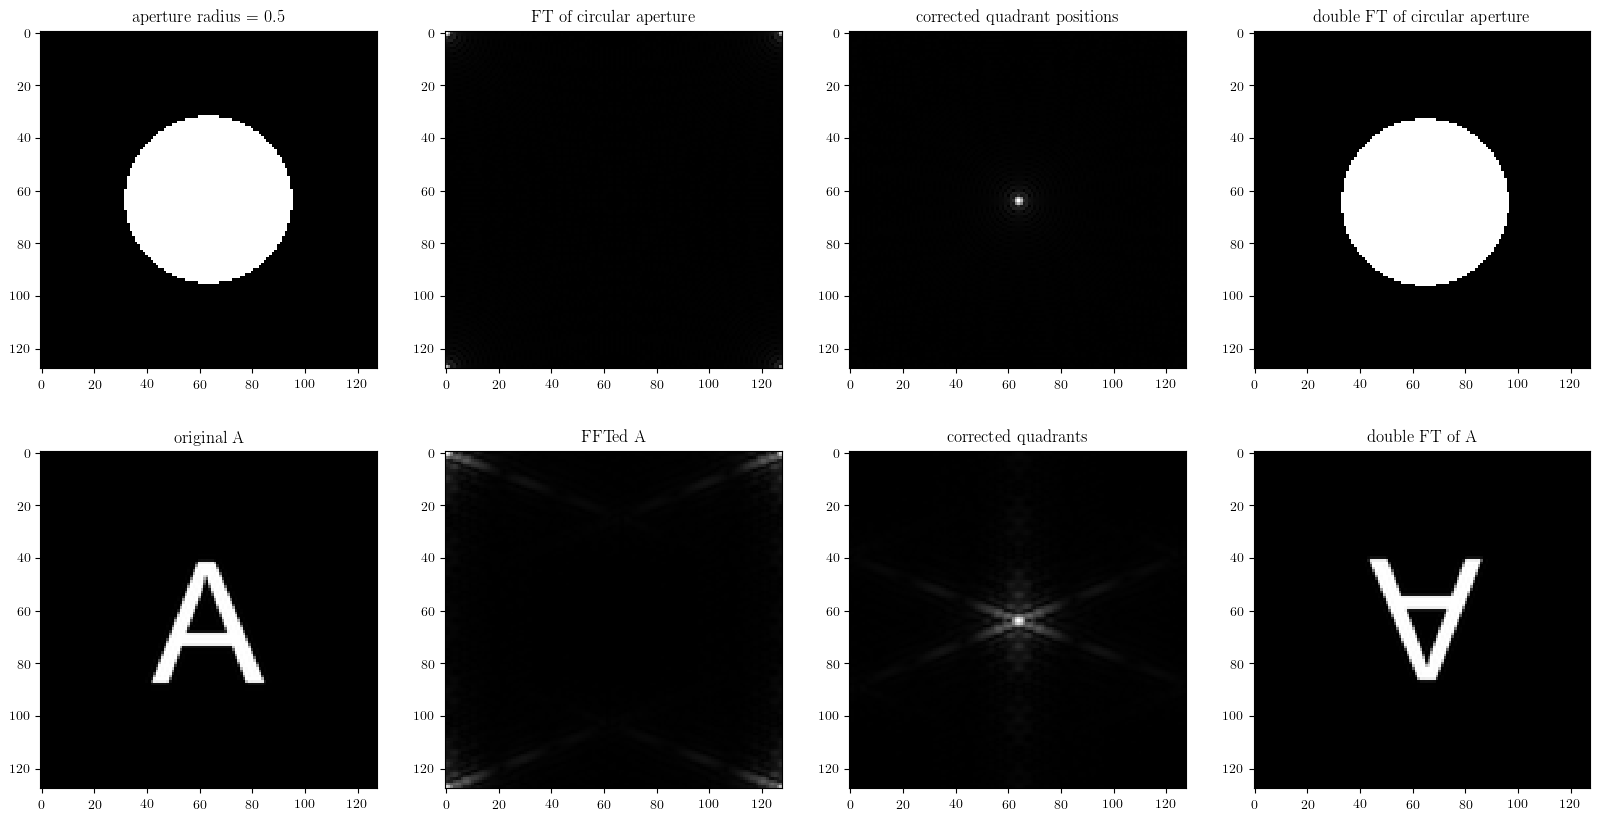

In [21]:
Z = ImgModel.generate_aperture(0.5, 128)
A = ImgModel.generate_txtImage(170, 120, text="A")
fig = mp.figure(figsize=(5*4, 5*2))

ax = fig.add_subplot(241)
ax.imshow(Z, "gray")
ax.set_title("aperture radius = 0.5")

ax = fig.add_subplot(242)
FZ = fft.fft2(Z)
ax.imshow(uint8(FZ), "gray")
ax.set_title("FT of circular aperture")

ax = fig.add_subplot(243)
ax.imshow(uint8(fft.fftshift(FZ)), "gray")
ax.set_title("corrected quadrant positions")

ax = fig.add_subplot(244)
ax.imshow(uint8(fft.fft2(FZ)), "gray")
ax.set_title("double FT of circular aperture")

ax = fig.add_subplot(245)
ax.imshow(A, "gray")
ax.set_title("original A")

ax = fig.add_subplot(246)
FA = fft.fft2(A)
ax.imshow(uint8(FA), "gray")
ax.set_title("FFTed A")

ax = fig.add_subplot(247)
ax.imshow(uint8(fft.fftshift(FA)), "gray")
ax.set_title("corrected quadrants")

ax = fig.add_subplot(248)
ax.imshow(uint8(fft.fft2(FA)), "gray")
ax.set_title("double FT of A")

mp.show()

In the 2nd column, we see the quarters of a pattern in each corner. Applying <code>fftshift()</code> corrects the quadrant positions and we observe some sort of Airy pattern at the center. Applying <code>fft2()</code> again reverts them back to the spatial domain.

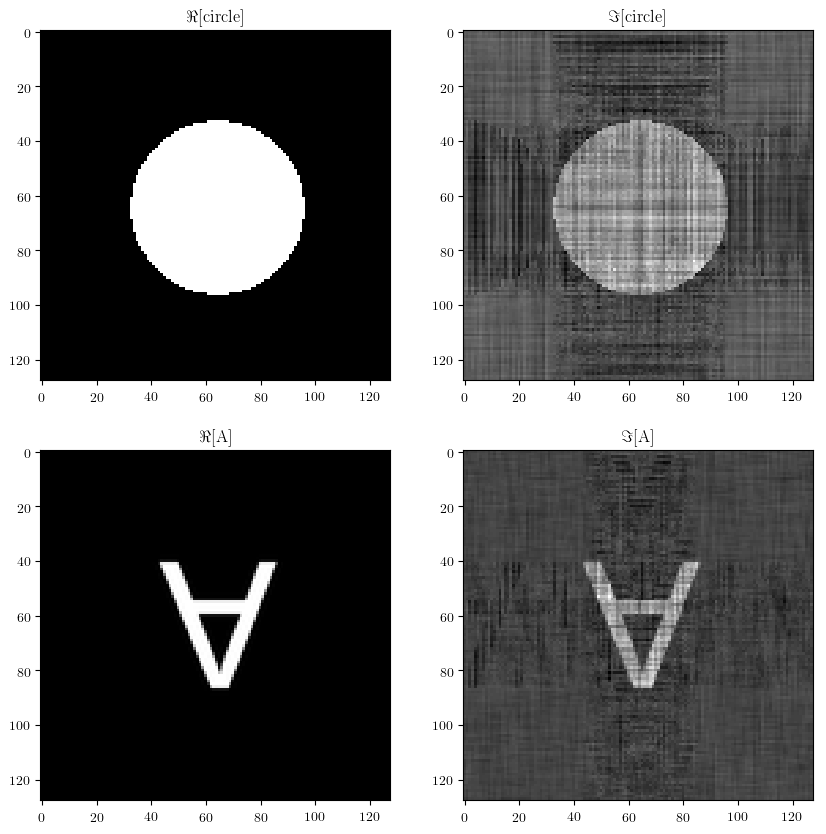

In [29]:
fig = mp.figure(figsize=(5*2, 5*2))

ax = fig.add_subplot(221)
ax.imshow(fft.fft2(FZ).real, "gray")
ax.set_title(r"$\Re$[circle]")

ax = fig.add_subplot(222)
ax.imshow(fft.fft2(FZ).imag, "gray")
ax.set_title(r"$\Im$[circle]")

ax = fig.add_subplot(223)
ax.imshow(fft.fft2(FA).real, "gray")
ax.set_title(r"$\Re$[A]")

ax = fig.add_subplot(224)
ax.imshow(fft.fft2(FA).imag, "gray")
ax.set_title(r"$\Im$[A]")

mp.show()

One can see that the FT of an image has both real and imaginary parts.

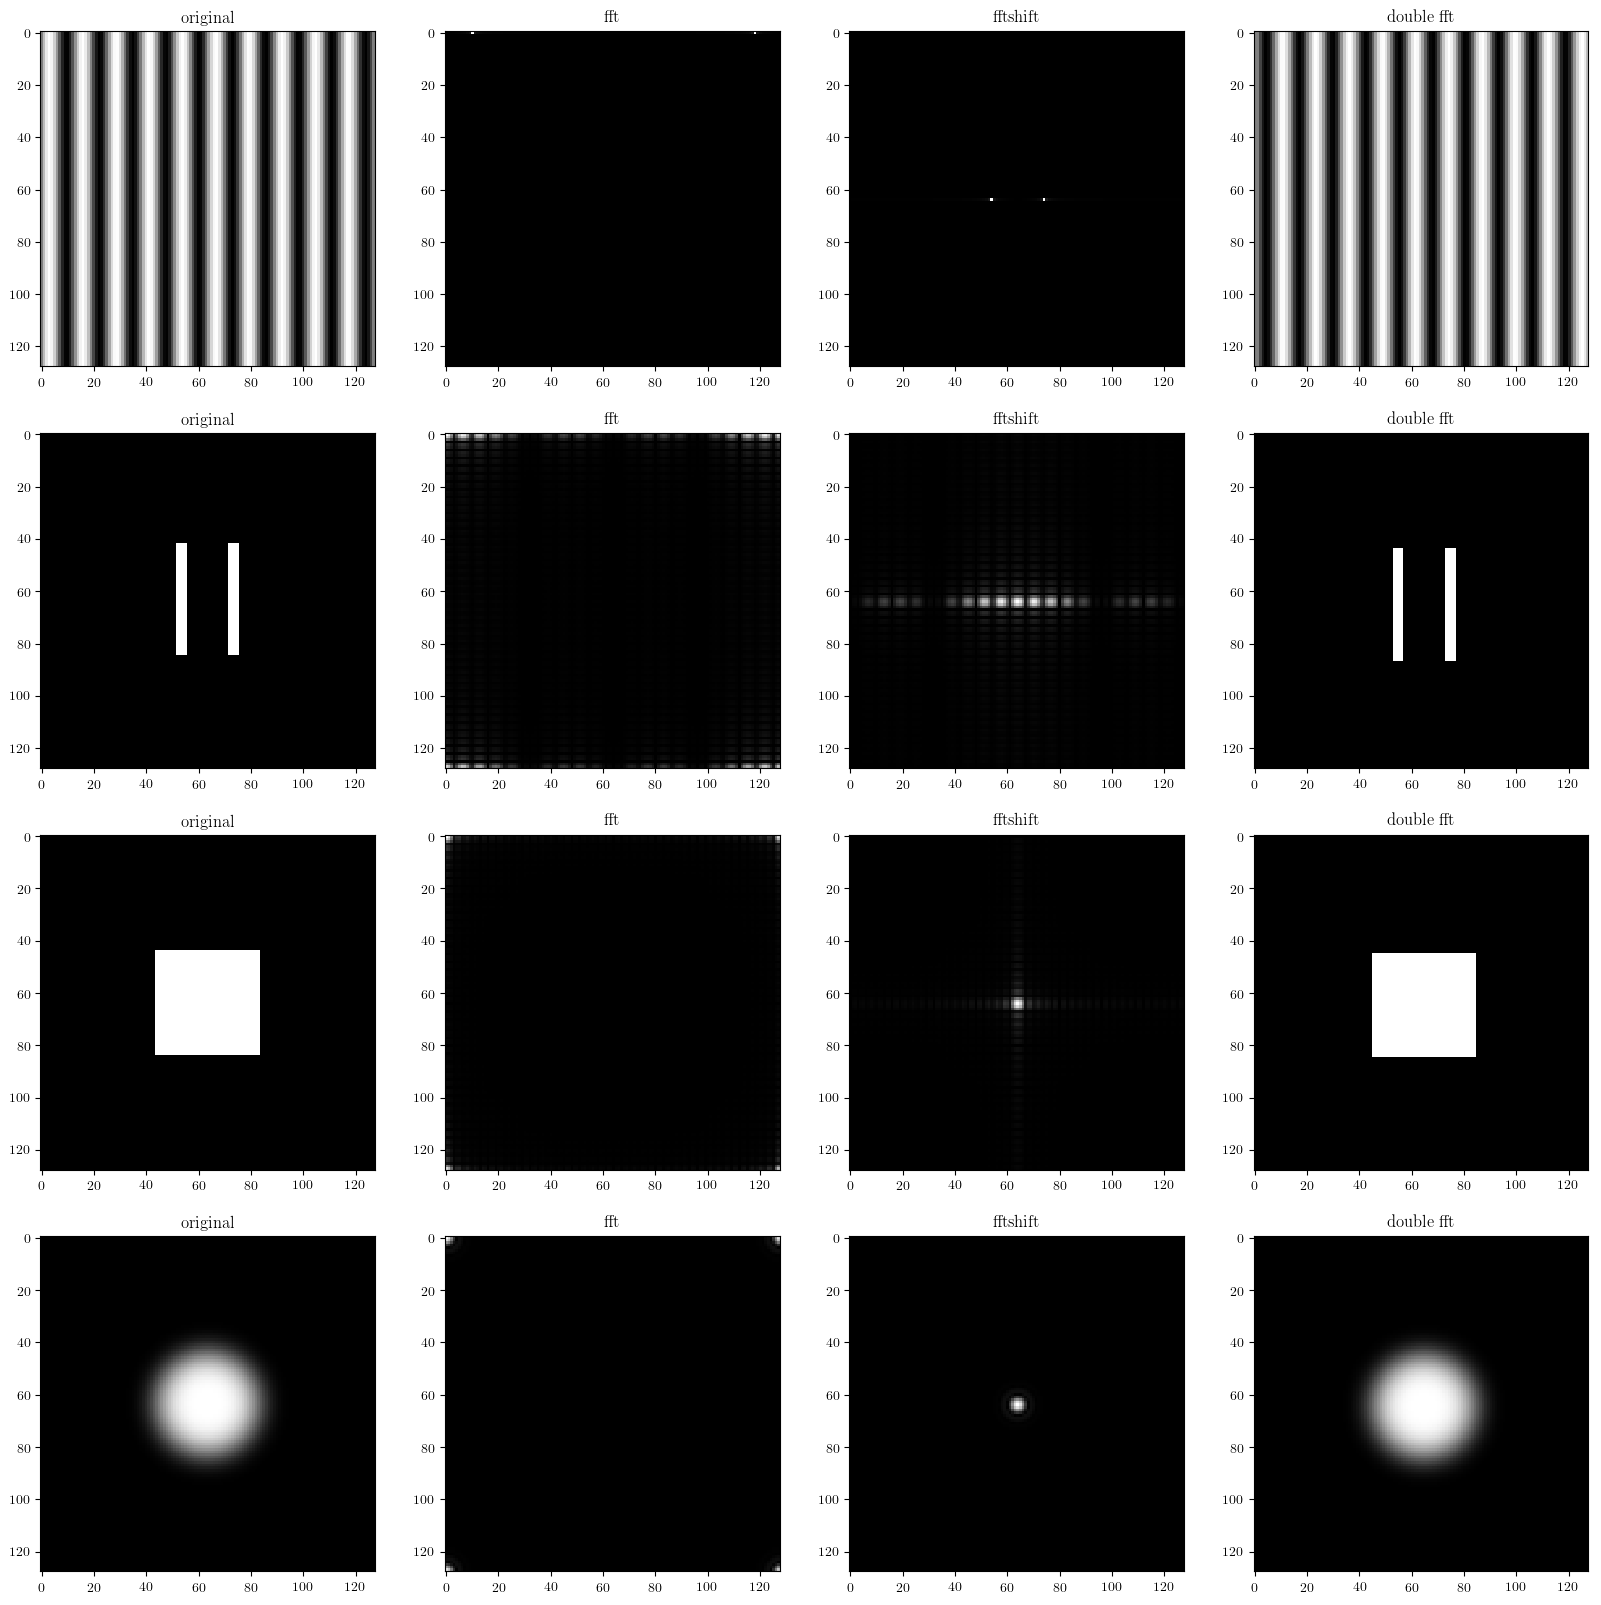

In [81]:
L = 128
Z = np.zeros((L, L, 4))
t = np.linspace(-10*np.pi, 10*np.pi, L)
X,Y = np.meshgrid(t,t)
Z[:,:,0] = np.sin(X)

Z[L//3:2*L//3, L//2-10-2:L//2-10+2, 1] = 1
Z[L//3:2*L//3, L//2+10-2:L//2+10+2, 1] = 1

Z[L//2-20:L//2+20, L//2-20:L//2+20, 2] = 1

Z[:,:,3] = fftgauss(X, Y, 0, 0, 100)

fig = mp.figure(figsize=(5*4, 5*4))

for i in range(4):
    ax = fig.add_subplot(4, 4, 4*i + 1)
    ax.imshow(Z[:,:,i], "gray")
    ax.set_title("original")

    ax = fig.add_subplot(4, 4, 4*i + 2)
    FZ = fft.fft2(Z[:,:,i])
    ax.imshow(uint8(FZ), "gray")
    ax.set_title("fft")

    ax = fig.add_subplot(4, 4, 4*i + 3)
    ax.imshow(uint8(fft.fftshift(FZ)), "gray")
    ax.set_title("fftshift")

    ax = fig.add_subplot(4, 4, 4*i + 4)
    ax.imshow((fft.fft2(FZ)).real, "gray")
    ax.set_title("double fft")

mp.show()

## Activity 2. Simulation of an imaging device

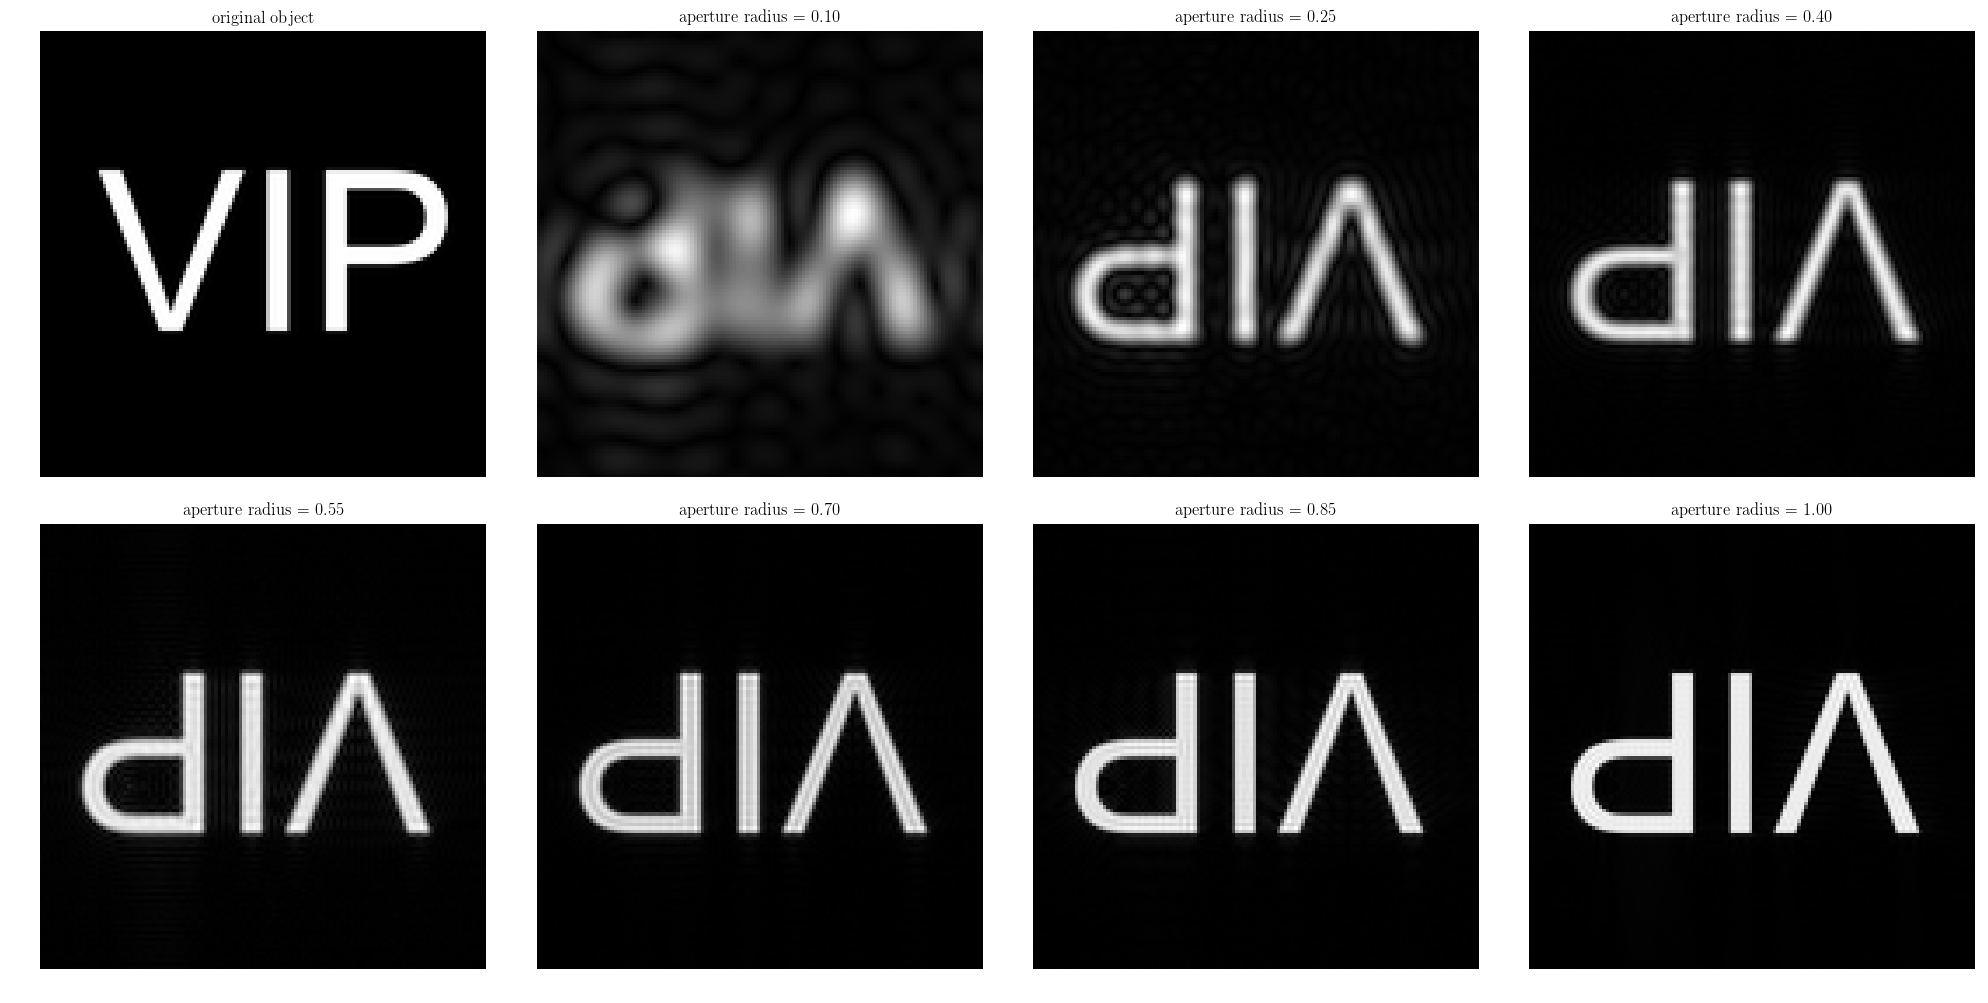

In [5]:
obj = ImgModel.generate_txtImage(66, 112, 512, "VIP", 256, "white", "black", True, 128)
aper_arr = np.linspace(0.1, 1, 7)

fig = mp.figure(figsize=(5*4, 5*2))

ax = fig.add_subplot(241)
ax.imshow(obj, "gray")
ax.axis("off")
ax.set_title("original object")

for i in range(7):
    aper = ImgModel.generate_aperture(rad=aper_arr[i], res=128)
    img = ImgModel.image_aperture(obj, aper)
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(img, "gray")
    ax.set_title("aperture radius = %.2f"%(aper_arr[i]))
    ax.axis("off")

mp.tight_layout()
mp.show()

We can observe that a wider aperture images the object more closely to the original.

## Activity 3. Template matching using correlation

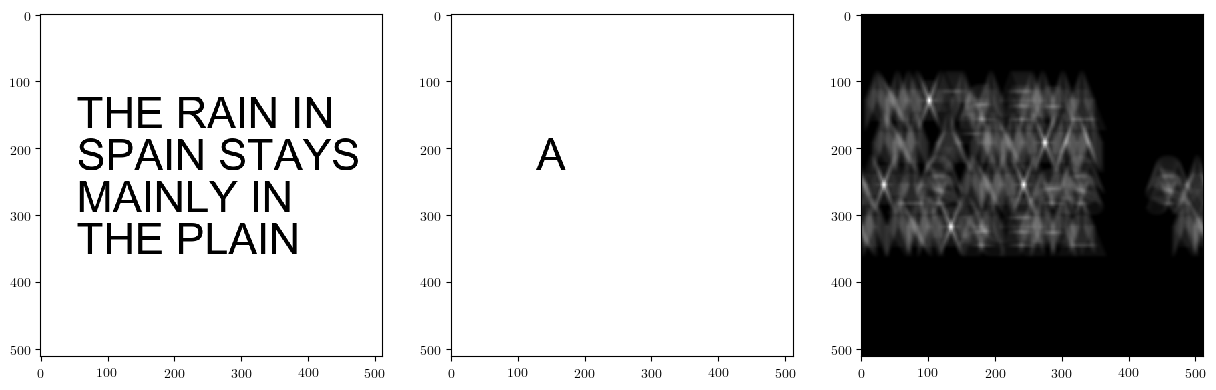

In [6]:
obj = ImgModel.generate_txtImage(55, 112, 512, "THE RAIN IN\nSPAIN STAYS\nMAINLY IN\nTHE PLAIN", 65, "black", "white", True, 512)
temp = ImgModel.generate_txtImage(128, 174, 512, "A", 65, "black", "white", True, 512)

fig = mp.figure(figsize=(5*3, 5))

ax = fig.add_subplot(131)
ax.imshow(obj, "gray")

ax = fig.add_subplot(132)
ax.imshow(temp, "gray")

Fobj = fft.fft2(obj)
Ftemp = fft.fft2(temp)
Fmatch = Ftemp*Fobj.conj()
Fimg = fft.fftshift(abs(fft.ifft2(Fmatch)))
ax = fig.add_subplot(133)
ax.imshow(Fimg, "gray")

mp.show()

We can observe that peaks arise in locations where there is a letter "A".

## Activity 4. Edge detection using convolution integral

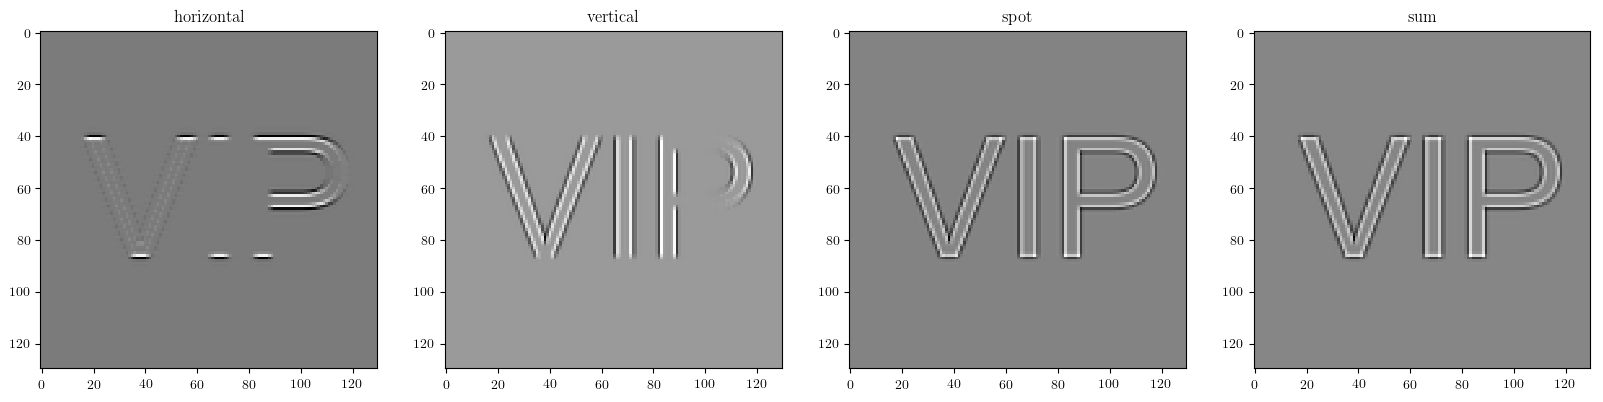

In [7]:
pat1 = np.array([[-1, -1, -1],
               [2, 2, 2],
               [-1, -1, -1]])
pat2 = pat1.T
pat3 = np.array([[-1, -1, -1],
                [-1, 8, -1],
                [-1, -1, -1]])

obj = ImgModel.generate_txtImage(66, 112, 512, "VIP", 256, "white", "black", True, 128)

fig = mp.figure(figsize=(5*4, 5))

img = sig.convolve2d(pat1, obj, "full")
fin = img.copy()
ax = fig.add_subplot(141)
ax.imshow(img, "gray")
ax.set_title("horizontal")

img = sig.convolve2d(pat2, obj, "full")
fin += img
ax = fig.add_subplot(142)
ax.imshow(img, "gray")
ax.set_title("vertical")

img = sig.convolve2d(pat3, obj, "full")
fin += img
ax = fig.add_subplot(143)
ax.imshow(img, "gray")
ax.set_title("spot")

ax = fig.add_subplot(144)
ax.imshow(fin, "gray")
ax.set_title("sum")

mp.show()

We can observe that the form of the direction pattern affects the orientation of the edges that are detected. Spot pattern shows the best performance.